In [2]:
import torch
import sklearn
import pandas as pd
import csv

In [3]:
SpamHam = pd.read_csv('spam_ham_dataset.csv')
SpamHam.head(5)

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [4]:
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score


def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

SpamHam['clean_text'] = SpamHam['text'].apply(clean_text)
SpamHam['clean_text'].head(5)


0    subject enron methanol meter this is a follow ...
1    subject hpl nom for january see attached file ...
2    subject neon retreat ho ho ho we re around to ...
3    subject photoshop windows office cheap main tr...
4    subject re indian springs this deal is to book...
Name: clean_text, dtype: object

In [5]:
def create_vocab(texts):
    vocab = set()
    for text in texts:
        words = text.split()
        vocab.update(words)
    return {word: idx for idx, word in enumerate(sorted(vocab))}

def text_to_bow(text, vocab):
    vector = torch.zeros(len(vocab))
    for word in text.split():
        if word in vocab:
            vector[vocab[word]] += 1
    return vector

vocabulary = create_vocab(SpamHam['clean_text'])
X = torch.stack([text_to_bow(text, vocabulary) for text in SpamHam['clean_text']])
y = torch.tensor(SpamHam['label_num'].values)


In [6]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class LogisticRegression(torch.nn.Module):
    def __init__(self, input_size):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_size, 1)
        
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

input_size = len(vocabulary)
model = LogisticRegression(input_size)

criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

num_epochs = 1000
for epoch in range(num_epochs):
    outputs = model(X_train.float())
    loss = criterion(outputs.squeeze(), y_train.float())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

with torch.no_grad():
    model.eval()
    y_pred_proba = model(X_test.float())
    y_pred = (y_pred_proba >= 0.5).squeeze().int()
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}')
    
    print(classification_report(y_test, y_pred, target_names=['ham', 'spam']))

Epoch 100/1000, Loss: 0.3735
Epoch 200/1000, Loss: 0.3163
Epoch 300/1000, Loss: 0.2839
Epoch 400/1000, Loss: 0.2614
Epoch 500/1000, Loss: 0.2442
Epoch 600/1000, Loss: 0.2303
Epoch 700/1000, Loss: 0.2188
Epoch 800/1000, Loss: 0.2090
Epoch 900/1000, Loss: 0.2005
Epoch 1000/1000, Loss: 0.1930
Accuracy: 0.9324
              precision    recall  f1-score   support

         ham       0.93      0.98      0.95       742
        spam       0.94      0.81      0.87       293

    accuracy                           0.93      1035
   macro avg       0.94      0.90      0.91      1035
weighted avg       0.93      0.93      0.93      1035



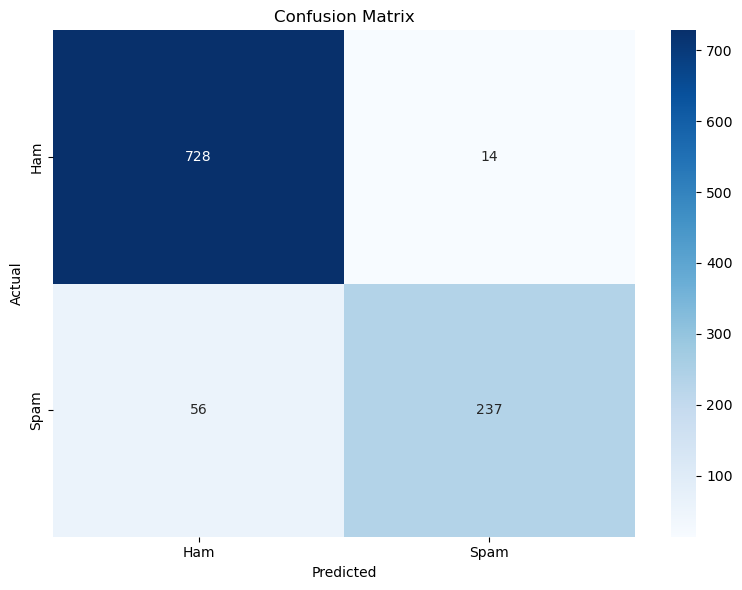

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

cm = confusion_matrix(y_test.numpy(), y_pred.numpy())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Ham', 'Spam'], 
            yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
